# Create a NetworkX street network from OpenStreetMap

In [1]:
import osmnx, networkx as nx, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
osmnx.init(file_log=True, use_cache=True)

## There are several different ways to construct the network

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

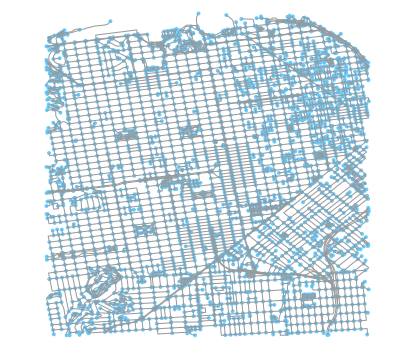

In [3]:
# define a bounding box in San Francisco
north, south, east, west = 37.81, 37.76, -122.40, -122.45

# create graph from that bounding box
G1 = osmnx.graph_from_bbox(north, south, east, west)
fig, ax = osmnx.plot_graph(G1)

#### Method #2, pass a lat-long point and bounding box distance in meters#### 
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

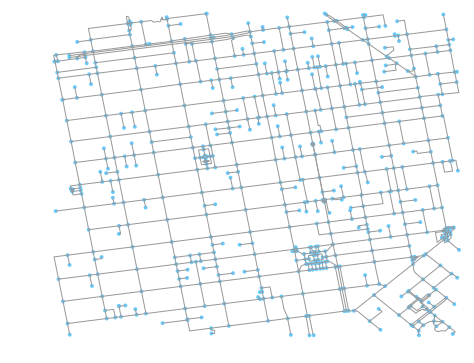

In [4]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create graph from point, inside bounding box of N, S, E, W each 750m from point
G2 = osmnx.graph_from_point(location_point, distance=750, distance_type='bbox')
fig, ax = osmnx.plot_graph(G2)

#### Method #3, pass a (lat,lon) point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it prunes the network by removing all nodes further than *n* meters from the point along the network.

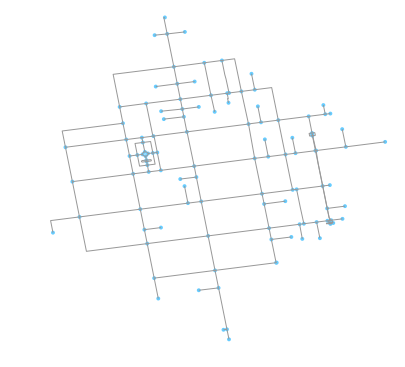

In [5]:
# same point again, but create graph only of nodes within 500m along the network from point
G3 = osmnx.graph_from_point(location_point, distance=500, distance_type='network')
fig, ax = osmnx.plot_graph(G3)

#### Method #4, pass an address and distance (bounding box or network) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance (if distance_type='network').

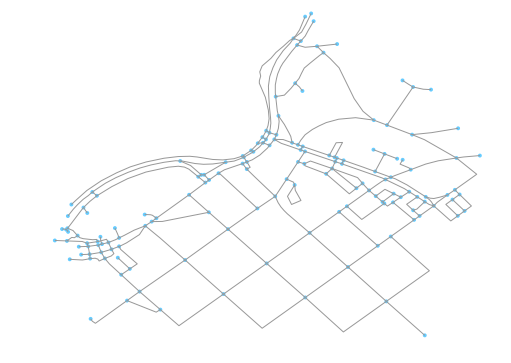

In [6]:
# graph from address, including only nodes within 500m along the network from the address
G4 = osmnx.graph_from_address(address='1611 2nd Ave, Oakland, CA 94606', 
                              distance=500, 
                              distance_type='network')
fig, ax = osmnx.plot_graph(G4)

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then prunes all nodes that lie outside the place's boundary polygon.

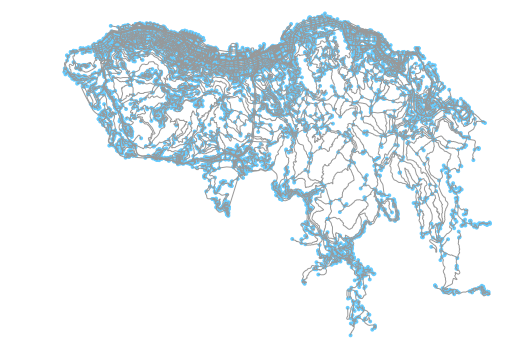

In [7]:
# create a graph constrained to the shape of hong kong island
G5 = osmnx.graph_from_place('Hong Kong Island', which_result=2)

# project the graph to UTM (zone calculated automatically) then plot it
G5_proj = osmnx.project_graph(G5)
fig, ax = osmnx.plot_graph(G5_proj)

## Calculate the network path from the centermost node to some other node
Let the origin node be the node nearest the location and let the destination node just be the last node in the graph. Then find the shortest path between origin and destination, using weight='length' to find the shortest spatial path (otherwise it treats each edge as weight=1).

In [8]:
# define a lat-long point, create graph around point, define origin/destionation nodes
location_point = (37.791427, -122.410018)
G = osmnx.graph_from_point(location_point, distance=500, distance_type='network', network_type='foot')
origin_node = osmnx.get_nearest_node(G, location_point)
destination_node = G.nodes()[-1]

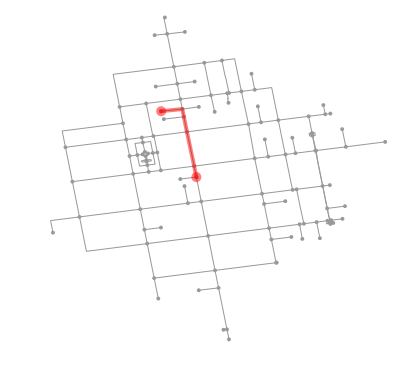

In [9]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = osmnx.plot_graph_route(G, route)

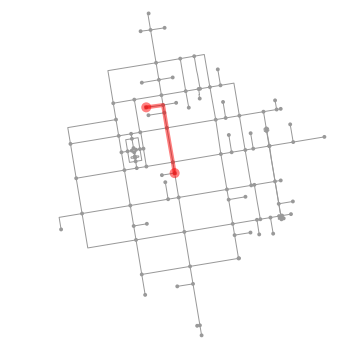

In [10]:
# project the graph to UTM (zone calculated automatically) then plot the network/route again
G_proj = osmnx.project_graph(G.copy())
fig, ax = osmnx.plot_graph_route(G_proj, route)

## Plot network path from one lat-long to another

In [11]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = osmnx.get_nearest_node(G, origin_point)
destination_node = osmnx.get_nearest_node(G, destination_point)
origin_node, destination_node

(319, 286)

In [12]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[319, 419, 438, 430, 161, 384, 605, 600, 570, 336, 334, 35, 286]'

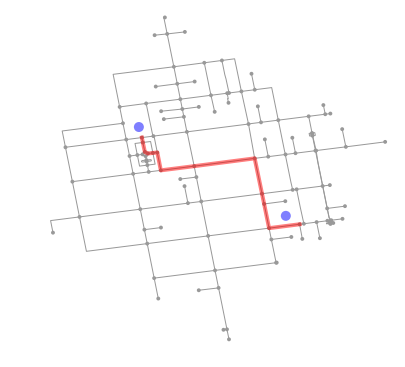

In [13]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = osmnx.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)